# sympy prep

In [1]:
from IPython.display import display
from sympy.printing import ccode
from sympy import cos, Symbol, Function, init_printing, Float
# from sympy import UnevaluatedExpr
import sympy
import numpy as np

class Value:
    values_by_name = {}
    def __init__(self, name, value):
        self.name = name
        self.value = value
        self.sympy = Symbol(self.name)
        Value.values_by_name[self.name] = self
    @staticmethod
    def get(name):
        return Value.values_by_name[name]
    @staticmethod
    def s(name):
        return Value.get(name).sympy
    @staticmethod
    def subs():
        return {x.sympy : Float(x.value, 10) for x in Value.values_by_name.values() if isinstance(x, Param)}
#     @staticmethod
#     def subs_uneval():
#         return {x.sympy : UnevaluatedExpr(x.value) for x in Value.values_by_name.values() if isinstance(x, Param)}
class Var(Value):
    def __init__(self, name, initial_value):
        super().__init__(name, initial_value)
class VarIndependent(Var):
    def __init__(self, name, initial_value, step):
        super().__init__(name, initial_value)
        self.step = step
class VarDependent(Var):
    def __init__(self, name, initial_value, derivative_order):
        super().__init__(name, initial_value)
        self.derivative_order = derivative_order
class Param(Value):
    def __init__(self, name, value):
        super().__init__(name, value)

# to uzupełnia user:

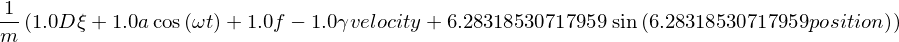

In [2]:
U = lambda x: sympy.cos(2*np.pi*x)
rhs_values = [
    # name, value
    Param('m', 9.931),
    Param('gamma', 1.0),
    Param('a', 5.125),
    Param('omega', 3.749),
    Param('f', 1.0),
    Param('D', 0.0001),
    Param('xi', 0.0),
    # name, initial value, derivative order
    VarDependent('position', 0.0, 0),
    VarDependent('velocity', 1.0, 1),
    # name, initial value, step
    VarIndependent('t', 0.0,  0.0020949113096826), # 2*PI/(omega*steps_per_period)
]

## simple case
# U = lambda x: 0
# rhs_values = [
#     Param('m', 1.0),
#     Param('gamma', 0.0),
#     Param('a', 0.0),
#     Param('omega', 0.0),
#     Param('f', -9.81),
#     Param('D', 0.0),
#     Param('xi', 0.0),
#     VarDependent('position', 0.0, 0),
#     VarDependent('velocity', 10*np.sin(np.pi/4), 1),
#     VarIndependent('t', 0.0,  0.001), # 2*PI/(omega*steps_per_period)
# ]

## equation
# a = 1.0 / m * (-gamma * Velocity - U_deriv(Position) + a * cosf(omega * T) + f + D * xi)
rhs = 1.0 / Value.s('m') * (-Value.s('gamma') * Value.s('velocity') - \
     sympy.diff(U(Value.s('position')), Value.s('position')) \
    + Value.s('a') * sympy.cos(Value.s('omega') * Value.s('t')) \
    + Value.s('f') + Value.s('D') * Value.s('xi'))



init_printing()
display(rhs)
display(rhs.free_symbols)
display(rhs.subs(Value.subs()))
# display(rhs.subs(Value.subs_uneval())) # w najnowszej wersji sympy

# mako context prep

In [3]:
def get_mako_ctx(rhs, rhs_values):
    params = {x.name : x.value for x in Value.values_by_name.values() if isinstance(x, Param)}
    variables = {}
    for x in Value.values_by_name.values():
        if isinstance(x, VarIndependent):
            variables[-1] = x
        elif isinstance(x, VarDependent):
            variables[x.derivative_order] = x
    sim = {}
    sim['periods'] = 1
    sim['steps_per_period'] =  2000
    sim['steps_per_kernel_call'] = 200
    sim['number_of_threads'] =  4
    sim['afterstep_every'] = 1
    
    rhs_string = ccode(rhs.subs(Value.subs()))
    rhs_string = rhs_string.replace('cos', 'cosf').replace('sin', 'sinf').replace('pow', 'powf')
    
    return {'params' : params,
            'variables' : variables,
            'sim' : sim,
            'rhs' : rhs_string,
           }

import pprint
pprint.pprint(get_mako_ctx(rhs, rhs_values))

{'params': {'D': 0.0001,
            'a': 5.125,
            'f': 1.0,
            'gamma': 1.0,
            'm': 9.931,
            'omega': 3.749,
            'xi': 0.0},
 'rhs': '-0.100694794079573*velocity + '
        '0.632684050670245*sinf(6.28318530717959*position) + '
        '0.51606081965781*cosf(3.749*t) + 0.100694794079573',
 'sim': {'afterstep_every': 1,
         'number_of_threads': 4,
         'periods': 1,
         'steps_per_kernel_call': 200,
         'steps_per_period': 2000},
 'variables': {-1: <__main__.VarIndependent object at 0x7f9171f83cf8>,
               0: <__main__.VarDependent object at 0x7f9171f83c88>,
               1: <__main__.VarDependent object at 0x7f9171f83cc0>}}


# code generation

In [4]:
from mako.template import Template
from mako.lookup import TemplateLookup
import subprocess

ctx = get_mako_ctx(rhs, rhs_values)

lookup = TemplateLookup(directories=['/home/users/aleksander.hulist/phd/sde2'], output_encoding='utf-8', encoding_errors='replace')
sde_template = lookup.get_template('basic_source.mako')
kernel_source = sde_template.render(**ctx)

with open("./basic_source_generated.cu", 'wb') as file:
    file.write(kernel_source)

command = 'indent -linux -sob -l120 /home/users/aleksander.hulist/phd/sde2/basic_source_generated.cu'.split()
print(subprocess.check_output(command).decode('utf-8'))

# run

In [5]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.tools import clear_context_caches
from pycuda.compiler import SourceModule
import numpy as np
from math import ceil
import pycuda.gpuarray as gpuarray

mod = SourceModule(open('basic_source_generated.cu', 'r').read(), no_extern_c=True)

######## randoms
init_func = mod.get_function("_Z10initkerneli")
# fill_func = mod.get_function("_Z14randfillkernelPfi")
seed = np.int32(123456789)
nvalues = 1000 * 4
init_func(seed, block=(2,2,6), grid=(1,1,1))

######## run    
gpu_summary = gpuarray.to_gpu(np.zeros((4*6)).astype(np.float32).reshape((2,2,6)))
gpu_output = gpuarray.to_gpu(np.zeros((4*1)).astype(np.float32).reshape((2,2,1)))

kernel_calls = ceil(ctx['sim']['periods'] * ctx['sim']['steps_per_period'] / ctx['sim']['steps_per_kernel_call'])
print('kernel_calls:', kernel_calls)

mod.get_function("prepare_simulation")(gpu_summary, gpu_output, block=(2,2,1)) # _Z18prepare_simulationPf
for i in range(kernel_calls):
    mod.get_function("continue_simulation")(gpu_summary, gpu_output, block=(2,2,1)) # _Z19continue_simulationv
mod.get_function("end_simulation")(gpu_summary, gpu_output, block=(2,2,1)) # _Z14end_simulationv

summary = gpu_summary.get()
print('out:\n', summary)

clear_context_caches()

print("""
0:  position
1:  avg_over_period_position
2:  avg_over_periods_velocity
3:  velocity
4:  avg_over_period_velocity
5:  avg_over_periods_velocity
""")

kernel_calls: 10
out:
 [[[4.6036777e+00 2.2996333e+00 2.0949114e-03 1.1442649e+00 1.0983489e+00
   1.0010811e+00]
  [4.6036777e+00 2.2996333e+00 2.0949114e-03 1.1442649e+00 1.0983489e+00
   1.0010811e+00]]

 [[4.6036777e+00 2.2996333e+00 2.0949114e-03 1.1442649e+00 1.0983489e+00
   1.0010811e+00]
  [4.6036777e+00 2.2996333e+00 2.0949114e-03 1.1442649e+00 1.0983489e+00
   1.0010811e+00]]]

0:  position
1:  avg_over_period_position
2:  avg_over_periods_velocity
3:  velocity
4:  avg_over_period_velocity
5:  avg_over_periods_velocity

